In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt


# ------------------------- Config -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
batch_size = 128
epochs = 10

# Projection (embedding) size for center loss space
feat_dim = 256

# Loss weights
center_weight = 0.01    # tune 0.005–0.05
focal_weight  = 1.0


In [1]:
# ------------------------- Losses (your definitions) -------------------------
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        """
        features: (N, feat_dim)
        labels:   (N,) long
        """
        batch_size = features.size(0)
        centers_batch = self.centers.index_select(0, labels.long())
        center_loss = torch.sum((features - centers_batch) ** 2) / (2.0 * batch_size)
        return center_loss


class MultiClassFocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        # inputs: (N, C) logits if self.logits=True; else probs
        # targets: (N,) long
        if self.logits:
            bce = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        else:
            bce = -torch.log(inputs[range(targets.shape[0]), targets].clamp(min=1e-12))

        pt = torch.exp(-bce)
        f_loss = self.alpha * (1 - pt) ** self.gamma * bce
        return f_loss.mean() if self.reduce else f_loss


class FocalCenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device, alpha=1, gamma=2, logits=True, reduce=True,
                 center_weight=1.0, focal_weight=1.0):
        super(FocalCenterLoss, self).__init__()
        self.center_loss = CenterLoss(num_classes, feat_dim, device)
        self.focal_loss = MultiClassFocalLoss(alpha, gamma, logits, reduce)
        self.center_weight = center_weight
        self.focal_weight = focal_weight

    def forward(self, features, labels, outputs):
        # features: (N, feat_dim)  | labels: (N,) long | outputs: (N, C) logits
        loss_center = self.center_loss(features, labels)
        loss_focal  = self.focal_loss(outputs, labels)
        return self.center_weight * loss_center + self.focal_weight * loss_focal


In [2]:
# ------------------------- Data -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
num_classes = len(train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

# ------------------------- Backbone: DINOv2-S/14 (frozen) -------------------------
# Requires internet the first time to fetch weights.
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)

# Freeze backbone
for p in dinov2.parameters():
    p.requires_grad = False
dinov2.eval()

# DINOv2 ViT-S/14 outputs 384-d CLS features when head is Identity
feat_dim_backbone = 384
# IMPORTANT: make forward() return features, not logits
dinov2.head = nn.Identity()

@torch.no_grad()
def dino_features(x):
    # With head=Identity, forward returns features directly: (N, 384)
    return dinov2(x)

# ------------------------- Projection + Classifier + Loss -------------------------
proj = nn.Linear(feat_dim_backbone, feat_dim).to(device)      # trainable projection
cls_head = nn.Linear(feat_dim, num_classes).to(device)        # multiclass head

criterion = FocalCenterLoss(
    num_classes=num_classes,
    feat_dim=feat_dim,
    device=device,
    alpha=1.0,
    gamma=2.0,
    logits=True,
    reduce=True,
    center_weight=center_weight,
    focal_weight=focal_weight,
).to(device)

optimizer = optim.Adam([
    {"params": proj.parameters(), "lr": 1e-3},
    {"params": cls_head.parameters(), "lr": 1e-3},
    {"params": criterion.center_loss.parameters(), "lr": 5e-4},  # smaller LR for centers
])

# ------------------------- Train / Eval -------------------------
def train_one_epoch():
    proj.train(); cls_head.train()
    running = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():
                feats_backbone = dino_features(imgs)      # (N, 384)
            feats = proj(feats_backbone)                  # (N, feat_dim)
            logits = cls_head(feats)                      # (N, C)
            loss = criterion(feats, y, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    proj.eval(); cls_head.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = proj(dino_features(imgs))
        logits = cls_head(feats)
        loss = criterion(feats, y, logits)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


class_to_idx: {'Negative': 0, 'Positive': 1}


Using cache found in /home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main
/home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [5]:
save_path = "best_dinov2_fcl.pt"
# ------------------------- Run -------------------------
# best_acc = 0.0
for epoch in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    if acc > best_acc:
        best_acc = acc

        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": dinov2.state_dict(),  # frozen but saved for completeness
            "proj_state_dict": proj.state_dict(),
            "cls_state_dict": cls_head.state_dict(),
            "center_state_dict": criterion.center_loss.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc
        }, save_path)
        print(f"✅ New best acc: {best_acc:.3f} — model saved!")

    print(f"Epoch {epoch+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")
print(f"Best Acc: {best_acc:.3f}")
print(f"📦 Best model saved to: {save_path}")

Epoch 1/10 | train_loss 0.2880 | val_loss 0.3214 | acc 0.889


Epoch 2/10 | train_loss 0.2757 | val_loss 0.3225 | acc 0.899


Epoch 3/10 | train_loss 0.2690 | val_loss 0.3136 | acc 0.889


Epoch 4/10 | train_loss 0.2587 | val_loss 0.3155 | acc 0.894


Epoch 5/10 | train_loss 0.2545 | val_loss 0.3003 | acc 0.885


Epoch 6/10 | train_loss 0.2631 | val_loss 0.2948 | acc 0.894


Epoch 7/10 | train_loss 0.2608 | val_loss 0.3361 | acc 0.857


Epoch 8/10 | train_loss 0.2529 | val_loss 0.3029 | acc 0.871


Epoch 9/10 | train_loss 0.2453 | val_loss 0.2894 | acc 0.880


✅ New best acc: 0.908 — model saved!
Epoch 10/10 | train_loss 0.2313 | val_loss 0.2742 | acc 0.908
Best Acc: 0.908
📦 Best model saved to: best_dinov2_fcl.pt


              precision    recall  f1-score   support

    Negative     0.9419    0.9299    0.9359       157
    Positive     0.8226    0.8500    0.8361        60

    accuracy                         0.9078       217
   macro avg     0.8823    0.8900    0.8860       217
weighted avg     0.9089    0.9078    0.9083       217

Confusion Matrix:
 [[146  11]
 [  9  51]]


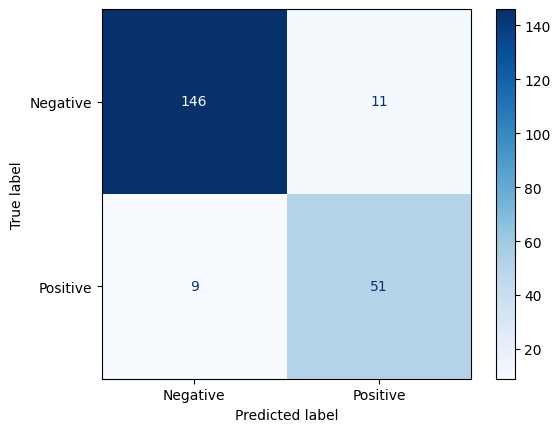

In [6]:

# ------------------------- Reports -------------------------
@torch.no_grad()
def collect_preds():
    proj.eval(); cls_head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = proj(dino_features(imgs))
        logits = cls_head(feats)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()

In [7]:

# ------------------------- Config -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
batch_size = 128
epochs = 10

# Projection (embedding) size for center loss space
feat_dim = 256

# Loss weights
center_weight = 0.01    # tune 0.005–0.05
focal_weight  = 1.0

# ------------------------- Data -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
num_classes = len(train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

# ------------------------- Backbone: DINOv2-S/14 (frozen) -------------------------
# Requires internet the first time to fetch weights.
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)

# Freeze backbone
for p in dinov2.parameters():
    p.requires_grad = True
dinov2.eval()

# DINOv2 ViT-S/14 outputs 384-d CLS features when head is Identity
feat_dim_backbone = 384
# IMPORTANT: make forward() return features, not logits
dinov2.head = nn.Identity()

@torch.no_grad()
def dino_features(x):
    # With head=Identity, forward returns features directly: (N, 384)
    return dinov2(x)

# ------------------------- Projection + Classifier + Loss -------------------------
proj = nn.Linear(feat_dim_backbone, feat_dim).to(device)      # trainable projection
cls_head = nn.Linear(feat_dim, num_classes).to(device)        # multiclass head

criterion = FocalCenterLoss(
    num_classes=num_classes,
    feat_dim=feat_dim,
    device=device,
    alpha=1.0,
    gamma=2.0,
    logits=True,
    reduce=True,
    center_weight=center_weight,
    focal_weight=focal_weight,
).to(device)

# ------------------------- Optimizer -------------------------
backbone_params = [p for p in dinov2.parameters() if p.requires_grad]

optimizer = optim.AdamW(
    [
        {"params": backbone_params,               "lr": 5e-5,  "weight_decay": 0.05},
        {"params": proj.parameters(),             "lr": 1e-3,  "weight_decay": 0.01},
        {"params": cls_head.parameters(),         "lr": 1e-3,  "weight_decay": 0.01},
        {"params": criterion.center_loss.parameters(), "lr": 5e-4, "weight_decay": 0.0},
    ],
    betas=(0.9, 0.999)
)

# ------------------------- Train / Eval -------------------------
def train_one_epoch():
    proj.train(); cls_head.train()
    running = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():
                feats_backbone = dino_features(imgs)      # (N, 384)
            feats = proj(feats_backbone)                  # (N, feat_dim)
            logits = cls_head(feats)                      # (N, C)
            loss = criterion(feats, y, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    proj.eval(); cls_head.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = proj(dino_features(imgs))
        logits = cls_head(feats)
        loss = criterion(feats, y, logits)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


import math

warmup_epochs = 2  # adjust if you increase total epochs
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    progress = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def train_one_epoch():
    dinov2.train(); proj.train(); cls_head.train()
    running = 0.0

    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            feats_backbone = dino_features(imgs)   # (N, 384)
            feats = proj(feats_backbone)           # (N, feat_dim)
            logits = cls_head(feats)               # (N, C)
            loss = criterion(feats, y, logits)

        scaler.scale(loss).backward()

        # gradient clipping helps when unfreezing big backbones
        torch.nn.utils.clip_grad_norm_(
            list(dinov2.parameters()) + list(proj.parameters()) + list(cls_head.parameters()),
            max_norm=1.0
        )

        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)

    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    dinov2.eval(); proj.eval(); cls_head.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            feats = proj(dino_features(imgs))
            logits = cls_head(feats)
            loss = criterion(feats, y, logits)

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


class_to_idx: {'Negative': 0, 'Positive': 1}


Using cache found in /home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main


In [13]:
# best_acc = 0.0
save_path = "best_dinov2_fcl.pt"

for epoch in range(epochs):
    train_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    scheduler.step()

    if acc > best_acc:
        best_acc = acc

        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": dinov2.state_dict(),  # frozen but saved for completeness
            "proj_state_dict": proj.state_dict(),
            "cls_state_dict": cls_head.state_dict(),
            "center_state_dict": criterion.center_loss.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc
        }, save_path)
        print(f"✅ New best acc: {best_acc:.3f} — model saved!")

    print(f"Epoch {epoch+1:02d}/{epochs} | train_loss {train_loss:.4f} | "
          f"val_loss {val_loss:.4f} | acc {acc*100:.2f}%")


Epoch 01/10 | train_loss 0.2147 | val_loss 0.2776 | acc 87.56%


Epoch 02/10 | train_loss 0.2014 | val_loss 0.2539 | acc 89.40%


Epoch 03/10 | train_loss 0.2009 | val_loss 0.2549 | acc 89.86%


✅ New best acc: 0.912 — model saved!
Epoch 04/10 | train_loss 0.1905 | val_loss 0.2486 | acc 91.24%


Epoch 05/10 | train_loss 0.1884 | val_loss 0.2410 | acc 89.86%


Epoch 06/10 | train_loss 0.1848 | val_loss 0.2518 | acc 88.94%


Epoch 07/10 | train_loss 0.1798 | val_loss 0.2459 | acc 90.32%


Epoch 08/10 | train_loss 0.1761 | val_loss 0.2426 | acc 90.32%


Epoch 09/10 | train_loss 0.1754 | val_loss 0.2426 | acc 90.32%


Epoch 10/10 | train_loss 0.1756 | val_loss 0.2418 | acc 90.32%


In [15]:
# ---------- LOAD WEIGHTS ----------
ckpt = torch.load(save_path, map_location=device)

# If you trained the backbone (requires_grad=True), load it; if you froze it, still safe to load.
dinov2.load_state_dict(ckpt["model_state_dict"], strict=True)
proj.load_state_dict(ckpt["proj_state_dict"], strict=True)
cls_head.load_state_dict(ckpt["cls_state_dict"], strict=True)
criterion.center_loss.load_state_dict(ckpt["center_state_dict"], strict=True)

dinov2.eval(); proj.eval(); cls_head.eval()

Linear(in_features=256, out_features=2, bias=True)

              precision    recall  f1-score   support

    Negative     0.9367    0.9427    0.9397       157
    Positive     0.8475    0.8333    0.8403        60

    accuracy                         0.9124       217
   macro avg     0.8921    0.8880    0.8900       217
weighted avg     0.9120    0.9124    0.9122       217

Confusion Matrix:
 [[148   9]
 [ 10  50]]


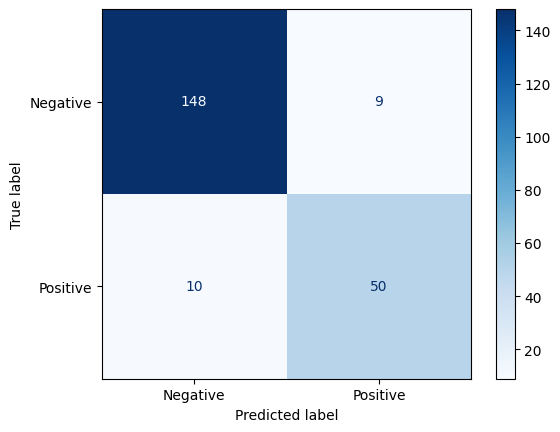

In [16]:
# ------------------------- Reports -------------------------
@torch.no_grad()
def collect_preds():
    proj.eval(); cls_head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = proj(dino_features(imgs))
        logits = cls_head(feats)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()